# IF on MNIST

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
from torch.autograd.functional import hessian
import torch.nn.functional as F

/home/xiaochen/anaconda3/envs/IFv2/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/xiaochen/anaconda3/envs/IFv2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd.functional import hessian
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
from sklearn.linear_model import LinearRegression
import sklearn.metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hessian on MOG with torch

In [3]:
num_train = 300

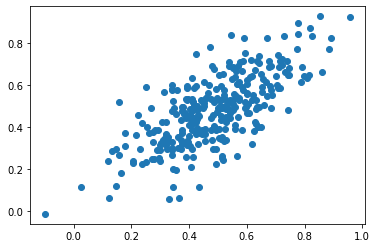

In [4]:
xx = np.array([0, 1])
yy = np.array([0, 1])
means = [xx.mean(), yy.mean()]  
stds = [xx.std()/3, yy.std()/3]
corr = 0.7         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, num_train).T
scatter(m[0], m[1])

In [5]:
x_1, y_1 = m.T[0]
x_1, y_1

(0.15706138173258988, 0.5211235134013863)

In [6]:
model = LinearRegression()
model.fit(np.array([m.T[:,0]]).T, m.T[:,1])

k, b = model.coef_[0], model.intercept_

In [7]:
k = torch.tensor([k], requires_grad=True)
b = torch.tensor([b], requires_grad=True)
k, b

(tensor([0.7303], dtype=torch.float64, requires_grad=True),
 tensor([0.1280], dtype=torch.float64, requires_grad=True))

In [8]:
w = torch.tensor([k, b])
w

tensor([0.7303, 0.1280], dtype=torch.float64)

In [9]:
def parent_mse_loss(w, x, y):
    def MSE_loss(w):
        return (torch.dot(w,torch.tensor([x, 1]))-y)**2
    return MSE_loss

def MSE_loss(w):
    return (torch.matmul(w[:2].reshape(-1,2),torch.tensor([x_1, 1]).reshape(2,1))-y_1)**2

def MSE_loss_all(w):
    Loss = 0
    for i in range(num_train):
        Loss = Loss + (torch.dot(w,torch.tensor([m.T[i][0], 1]))-m.T[i][1])**2
    return Loss

In [10]:
def CE_loss_test(w):

    divide1 = 4
    
    images = torch.tensor([[1.0,1.0]])

    labels = torch.tensor([0])

    #out1 = F.linear(images.reshape(-1, 784).to(device), w[:divide1].reshape(2,784), w[divide1:])


    mat1 = images.reshape(-1,2)

    mat2 = w[:divide1].reshape(2,2).t()
    
    out1 = w[divide1:].reshape(1,2) + torch.matmul(mat1, mat2) 
    loss = criterion(out1, labels)

    #loss = out1

    return loss

In [11]:
divide1 = 4
w = torch.tensor([2.0,2.0,2.0,2.0,2.0,2.0])
images = torch.tensor([[1.0,1.0]])
mat1 = images.reshape(-1,2)
mat2 = w[:divide1].reshape(2,2).t()
#torch.matmul(mat1, mat2)
out1 = w[divide1:].reshape(1,2) + torch.matmul(mat1, mat2) 
out1

tensor([[6., 6.]])

In [16]:
criterion = nn.CrossEntropyLoss()


In [17]:
w = torch.tensor([2.0,2.0,2.0,2.0,2.0,2.0])
CE_loss_test(w)

tensor(0.6931)

In [18]:
MSE_loss(w)

RuntimeError: expected scalar type Float but found Double

In [19]:
Hessian = torch.zeros([2,2])
for i in range(num_train):
    Hessian = Hessian + hessian(parent_mse_loss(w, m.T[i][0], m.T[i][1]), w)
Hessian/num_train

RuntimeError: dot : expected both vectors to have same dtype, but found Float and Double

In [20]:
hessian(MSE_loss_all, w)/num_train

RuntimeError: dot : expected both vectors to have same dtype, but found Float and Double

## Hessian on MNIST

### Set up before training

In [21]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download = True)

100%|████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 63452281.11it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 54812531.14it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 70908219.75it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

100%|██████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 14586928.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [22]:
input_size = 784 # 28*28
hidden_size = 32
num_classes = 10
num_epochs = 10
batch_size = 100 #100
learning_rate = 0.001

training_size = 60000
testing_size = 1000

In [23]:
np.random.seed(35)
training_selector = np.random.choice(range(60000), replace = False, size = training_size)
testing_selector = np.random.choice(range(10000), replace = False, size = testing_size)

In [6]:
class Alpha_Train_Dataset(Dataset):
  def __init__(self):
      
      self.x = train_dataset.data[training_selector].float()
      self.y = train_dataset.targets[training_selector]
      
      #self.n_samples = int(train_dataset.data.shape[0]*alpha)
      self.n_samples = len(training_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class Alpha_Test_Dataset(Dataset):
  def __init__(self):
      
      self.x = test_dataset.data[testing_selector].float()#[random_selector].float()
      self.y = test_dataset.targets[testing_selector]#[random_selector]
      
      self.n_samples = len(testing_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

In [7]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)
  
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

### Training

In [26]:
alpha_train_dataset = Alpha_Train_Dataset()
train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=batch_size, shuffle=True)

model = NeuralNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        #images = images.reshape(-1, 28*28).to(device) # can change -1 to 100
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

alpha_test_dataset = Alpha_Test_Dataset()
test_loader = torch.utils.data.DataLoader(dataset=alpha_test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # 把一个batch reshape 成一个 100 by 784 的 vector 来做prediction
        #images = images.reshape(-1, 28*28).to(device)
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
        labels = labels.to(device)
        output = model(images)
        # value, index
        _, predictions = torch.max(output, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100 * n_correct/n_samples

In [16]:
acc

96.1

In [ ]:
# with torch.no_grad():
#     out = model(alpha_train_dataset[0][0].reshape(-1, 784).to(device))
#     loss = criterion(out, torch.tensor([alpha_train_dataset[0][1]]))
#     print(loss)

### Calculate Hessian on numpy

In [17]:
def CE_loss(w_1, b_1, w_2, b_2):
    out1 = F.linear(alpha_train_dataset[1][0].reshape(-1, 784).to(device), w_1.reshape(hidden_size,784), b_1)
    out2 = F.relu(out1)
    out3 = F.linear(out2, w_2.reshape(10,hidden_size), b_2)
    loss = criterion(out3, torch.tensor([alpha_train_dataset[1][1]]).to(device))
    return loss

def CE_loss_new(w):
    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10
    out1 = F.linear(alpha_train_dataset[2][0].reshape(-1, 784).to(device), w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
    out2 = F.relu(out1)
    out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])
    loss = criterion(out3, torch.tensor([alpha_train_dataset[2][1]]).to(device))
    return loss

def CE_loss_new_all(w):
    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10

    Loss = []
    for i in range(training_size):
        out1 = F.linear(alpha_train_dataset[i][0].reshape(-1, 784).to(device), w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
        out2 = F.relu(out1)
        out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])
        loss = criterion(out3, torch.tensor([alpha_train_dataset[i][1]]).to(device))
        Loss.append(loss)
    return sum(Loss)

def CE_loss_new_all2(w):
    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10
    
    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=training_size, shuffle=False)
    examples = iter(train_loader)
    images, labels = examples.next()
    images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
    out2 = F.relu(out1)
    out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])
    loss = criterion(out3, labels.to(device))

    return loss

In [ ]:
#w_1, b_1, w_2, b_2 = list(model.parameters())
#w_1, b_1, w_2, b_2 = [_.view(-1) for _ in model.parameters()]
#CE_loss(w_1, b_1, w_2, b_2)

In [ ]:
# w = torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
# CE_loss_new_all2(w)

In [ ]:
#with torch.no_grad():
#    H = hessian(CE_loss, tuple([_.view(-1) for _ in model.parameters()]))
with torch.no_grad():
   Hessian = hessian(CE_loss_new_all2, torch.cat(tuple([_.view(-1) for _ in model.parameters()])))

In [ ]:
# with torch.no_grad():
#    Hessian = hessian(CE_loss_new, torch.cat(tuple([_.view(-1) for _ in model.parameters()])))

In [ ]:
np_Hessian = Hessian.to("cpu").numpy()/training_size

In [ ]:
damping_matrix = np.diag(np.full(Hessian.shape[0],0.01),0)
damping_matrix

array([[0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.01, 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.01]])

In [ ]:
damping_hessian = np_Hessian + damping_matrix

#### Save hessian

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np

In [ ]:
np.save("/content/gdrive/MyDrive/hessian_damping_32_hiddensize", damping_hessian)

#### Save model weight

In [ ]:
w = torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
np_w = w.to("cpu").detach().numpy()

In [ ]:
np.save("/content/gdrive/MyDrive/model_weight_32_hiddensize", np_w)

#### Load hessian and weight

In [ ]:
np_Hessian = np.load("/content/gdrive/MyDrive/hessian_damping_32_hiddensize.npy")

In [ ]:
np_w = np.load("/content/gdrive/MyDrive/model_weight_32_hiddensize.npy")

In [ ]:
inv_hessian = np.linalg.inv(np_Hessian)

In [ ]:
np.save("/content/gdrive/MyDrive/hessian_damping_inverse_32_hiddensize", inv_hessian)

In [ ]:
inv_hessian = np.load("/content/gdrive/MyDrive/hessian_damping_inverse_32_hiddensize.npy")

In [ ]:
np.matmul(np_Hessian, inv_hessian)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  2.84550131e-22,  5.95570041e-23],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.62482817e-23,  1.00000000e+00,  1.19114008e-22],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.41129285e-21, -6.70016296e-22,  1.00000000e+00]])

### Calculate Hessian on torch

In [18]:
def CE_loss_new_all2(w):
    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10
    
    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=training_size, shuffle=False)
    examples = iter(train_loader)
    images, labels = examples.next()

    images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
    out2 = F.relu(out1)
    out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])
    loss = criterion(out3, labels.to(device))*training_size

    return loss

In [19]:
with torch.no_grad():
   Hessian = hessian(CE_loss_new_all2, torch.cat(tuple([_.view(-1) for _ in model.parameters()])))/training_size

In [ ]:
damping_matrix = torch.tensor(np.diag(np.full(Hessian.shape[0],0.001),0)).to(device)
damping_hessian = Hessian + damping_matrix

In [ ]:
inv_hessian = torch.linalg.inv(damping_hessian)

In [ ]:
w = torch.cat(tuple([_.view(-1) for _ in model.parameters()]))

### Save and reload to save space

In [22]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [23]:
np_damping_hessian = damping_hessian.to("cpu").numpy()

np.save("/content/gdrive/MyDrive/hessian_damping_32_hiddensize", np_damping_hessian)

w = torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
np_w = w.to("cpu").detach().numpy()
np.save("/content/gdrive/MyDrive/model_weight_32_hiddensize", np_w)

In [8]:
np_Hessian = np.load("/content/gdrive/MyDrive/hessian_damping_32_hiddensize.npy")
np_w = np.load("/content/gdrive/MyDrive/model_weight_32_hiddensize.npy")
damping_hessian = torch.from_numpy(np_Hessian).to(device)
w = torch.from_numpy(np_w).to(device)

In [9]:
#damping_matrix = torch.tensor(np.diag(np.full(Hessian.shape[0],0.001),0)).to(device)
#damping_hessian = Hessian + damping_matrix
inv_hessian = torch.linalg.inv(damping_hessian)

RuntimeError: ignored

### Calculate IF for alpha train

In [ ]:
target_example = alpha_test_dataset[10][0] # it's a 9
plt.imshow(target_example, cmap = "gray")

In [ ]:
def loss_grad_at_point(w, train_point):
    # w should be torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
    # train_point should be alpha_train_dataset[0], a tuple of image and label

    w = w.clone().detach().requires_grad_(True)

    divide = 10*784

    out = F.linear(train_point[0].reshape(-1, 784).to(device), w[:divide].reshape(10,784), w[divide:])

    loss = criterion(out, torch.tensor([train_point[1]]).to(device))
    
    loss.backward()

    return w.grad

In [ ]:
#w = torch.cat(tuple([_.view(-1) for _ in model.parameters()]))

In [ ]:
def calculate_if(train_point, test_point, inv_Hessian):
    # test point should be alpha_test_dataset[10]

    test_loss = loss_grad_at_point(w, test_point)

    train_loss = loss_grad_at_point(w, train_point)

    if_score = -torch.matmul(torch.matmul(test_loss.t().double(), inv_Hessian), train_loss.double())

    return if_score

In [ ]:
if_score_list = []
for i in range(training_size):
    if_score = calculate_if(alpha_train_dataset[i], alpha_test_dataset[10], inv_hessian)
    if_score_list.append(if_score.item())

In [ ]:
if_score_series = pd.Series(if_score_list)
if_score_series_sorted = if_score_series.sort_values(ascending = False)
if_score_series_sorted

In [ ]:
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(alpha_train_dataset[3853][0], cmap = "gray")
axs[0][1].imshow(alpha_train_dataset[1949][0], cmap = "gray")
axs[0][2].imshow(alpha_train_dataset[3209][0], cmap = "gray")
axs[1][0].imshow(alpha_train_dataset[624][0], cmap = "gray")
axs[1][1].imshow(alpha_train_dataset[1650][0], cmap = "gray")
axs[1][2].imshow(alpha_train_dataset[5446][0], cmap = "gray")

### Calculate IF on ordered dataset

test point

In [ ]:
criterion = nn.CrossEntropyLoss()

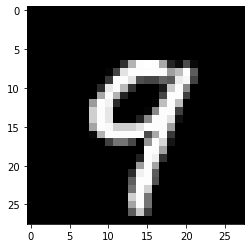

In [ ]:
#target_example = alpha_test_dataset[10][0] # it's a 9
#plt.imshow(target_example, cmap = "gray")
plt.imshow(test_dataset.data[12], cmap = "gray")

In [ ]:
test_point = (test_dataset.data[12].float(), test_dataset.targets[12])

In [ ]:
def loss_grad_at_point(w, train_point):
    # w should be torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
    # train_point should be alpha_train_dataset[0], a tuple of image and label

    w = w.clone().detach().requires_grad_(True)

    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10

    images = ((train_point[0].reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = F.linear(images, w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
    out2 = F.relu(out1)
    out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])

    loss = criterion(out3, torch.tensor([train_point[1]]).to(device))
    loss.backward()

    return w.grad

In [ ]:
#w = torch.tensor(np_w).to(device)
#inv_hessian = torch.tensor(inv_hessian).to(device).float()

### Calculate if score

In [ ]:
def calculate_if(train_point, test_point, inv_Hessian):
    # test point should be alpha_test_dataset[10]

    test_loss = loss_grad_at_point(w, test_point)#.to("cpu").numpy()

    train_loss = loss_grad_at_point(w, train_point)#.to("cpu").numpy()

    if_score = -torch.matmul(torch.matmul(test_loss.t(), inv_Hessian), train_loss)

    return if_score

In [ ]:
test_point = (test_dataset.data[12].float(), test_dataset.targets[12])
if_score_list = []
for i in range(training_size):
    train_point = (train_dataset.data[i].float(), train_dataset.targets[i])
    if_score = calculate_if(train_point, test_point, inv_hessian)
    if_score_list.append(if_score)
    if (i+1) % 100 == 0:
        print(f"{i+1}/60000 complete")

In [ ]:
len(if_score_list)

60000

### Result

In [ ]:
if_score_series = pd.Series(torch.tensor(if_score_list).to("cpu"))

In [ ]:
if_score_series_sorted = if_score_series.sort_values(ascending = False)

In [ ]:
if_score_series_sorted

36907    2883.714111
12028    2265.501465
26778    2208.476074
45238    2163.090088
1244     2130.077881
            ...     
18118   -1945.744263
6156    -1973.395874
31840   -2066.142334
51248   -2464.245605
14582   -3051.974854
Length: 60000, dtype: float32

In [ ]:
np.save("/content/gdrive/MyDrive/if_scores_32_hiddensize", torch.tensor(if_score_list).to("cpu").numpy())

#### Plot the result

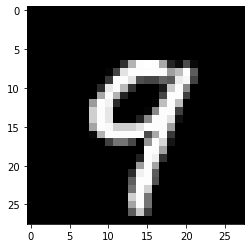

In [ ]:
plt.imshow(test_dataset.data[12], cmap = "gray")

In [ ]:
alpha_train_dataset[47085][1]

tensor(4)

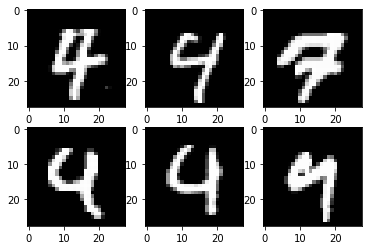

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(train_dataset.data[36907], cmap = "gray")
axs[0][1].imshow(train_dataset.data[12028], cmap = "gray")
axs[0][2].imshow(train_dataset.data[26778], cmap = "gray")
axs[1][0].imshow(train_dataset.data[14582], cmap = "gray")
axs[1][1].imshow(train_dataset.data[51248], cmap = "gray")
axs[1][2].imshow(train_dataset.data[31840], cmap = "gray")
#alpha_train_dataset[if_score_series_sorted.index[-1]][0]

# IF vs LOOT

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
from sklearn.linear_model import LinearRegression
import sklearn.metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
if_score_list = np.load("/content/gdrive/MyDrive/if_scores_32_hiddensize.npy")
if_score_series = pd.Series(if_score_list)
if_score_series_sorted = if_score_series.sort_values(ascending = False)

In [ ]:
idx_to_remove = np.array(if_score_series_sorted.apply(lambda x: abs(x)).sort_values(ascending = False).index[:50])

In [ ]:
diff_in_loss_by_if = np.array(if_score_series[idx_to_remove]/(-60000))

In [ ]:
idx_to_remove

array([14582, 36907, 51248, 12028, 26778, 45238,  1244, 13850, 31840,
       47600,  6156, 18118, 46384, 32342, 24756, 20211, 49547, 27292,
       13350, 51125, 56220, 15741, 55730, 29929, 46643, 20652,  5821,
       16992, 22722, 45761,  8268, 48786, 25806, 53528, 43658, 37248,
       32391, 45749, 50329, 20600,  1854, 24719,   148,  8468,  5559,
       27180, 56268, 47227, 48522, 31428])

In [ ]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download = True)

In [ ]:
input_size = 784 # 28*28
hidden_size = 32
num_classes = 10
num_epochs = 10
batch_size = 100 #100
learning_rate = 0.001

training_size = 60000
testing_size = 1000

testing_selector = np.random.choice(range(10000), replace = False, size = testing_size)

In [ ]:
class One_Out_Train_Dataset(Dataset):
  def __init__(self, training_selector):
      
      self.x = train_dataset.data[training_selector].float()
      self.y = train_dataset.targets[training_selector]
      
      #self.n_samples = int(train_dataset.data.shape[0]*alpha)
      self.n_samples = len(training_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class Alpha_Test_Dataset(Dataset):
  def __init__(self):
      
      self.x = test_dataset.data[testing_selector].float()#[random_selector].float()
      self.y = test_dataset.targets[testing_selector]#[random_selector]
      
      self.n_samples = len(testing_selector)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, num_classes)
  
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    return out

In [ ]:
test_point = (test_dataset.data[12].float(), test_dataset.targets[12])
test_image = test_point[0].reshape(-1, 28*28).to(device)
test_label = torch.tensor([test_point[1]]).to(device)

In [ ]:
original_test_loss = 0.0003

In [ ]:
change_in_loss_lst = []
counter = 1
for idx in idx_to_remove:
    training_selector = np.concatenate((np.arange(0,idx), np.arange(idx+1,60000)))

    alpha_train_dataset = One_Out_Train_Dataset(training_selector)

    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=batch_size, shuffle=True)

    model = NeuralNet(input_size, hidden_size, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # 100, 1, 28, 28
            images = images.reshape(-1, 28*28).to(device) # can change -1 to 100
            labels = labels.to(device)

            # forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        test_output = model(test_image)
        test_loss = criterion(test_output, test_label)
        change_in_loss_lst.append(test_loss.item() - original_test_loss)
        counter = counter + 1
        print(f"{counter}/50 complete")

    # alpha_test_dataset = Alpha_Test_Dataset()
    # test_loader = torch.utils.data.DataLoader(dataset=alpha_test_dataset, batch_size=batch_size, shuffle=False)

    # with torch.no_grad():
    #     n_correct = 0
    #     n_samples = 0
    #     for images, labels in test_loader:
    #         # 把一个batch reshape 成一个 100 by 784 的 vector 来做prediction
    #         images = images.reshape(-1, 28*28).to(device)
    #         labels = labels.to(device)
    #         output = model(images)
    #         # value, index
    #         _, predictions = torch.max(output, 1)
    #         n_samples += labels.shape[0]
    #         n_correct += (predictions == labels).sum().item()
    #     acc = 100 * n_correct/n_samples
    #     print(acc)

#### calculate original test loss

In [ ]:
def loss_at_point(w, train_point):
    # w should be torch.cat(tuple([_.view(-1) for _ in model.parameters()]))
    # train_point should be alpha_train_dataset[0], a tuple of image and label

    w = w.clone().detach()

    divide1 = hidden_size*784
    divide2 = divide1 + hidden_size
    divide3 = divide2 + hidden_size*10

    out1 = F.linear(train_point[0].reshape(-1, 784).to(device), w[:divide1].reshape(hidden_size,784), w[divide1:divide2])
    out2 = F.relu(out1)
    out3 = F.linear(out2, w[divide2:divide3].reshape(10,hidden_size), w[divide3:])

    loss = criterion(out3, torch.tensor([train_point[1]]).to(device))
    

    return loss

In [ ]:
#loss_at_point(w, test_point)

tensor(0.0003, device='cuda:0')

#### end of test loss

In [ ]:
change_in_loss_array = np.array([_.item() for _ in change_in_loss_lst])

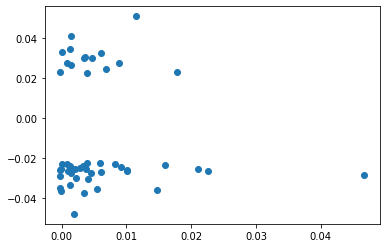

In [ ]:
scatter(change_in_loss_array, diff_in_loss_by_if)

# Logistic Regression comparison

In [8]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd.functional import hessian
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter
from sklearn.linear_model import LinearRegression
import sklearn.metrics

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [9]:
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]), download = True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]), download = True)

In [10]:
train_index = []
train_labels = []
for i, digit in enumerate(train_dataset.targets):
    if digit == 1:
        train_index.append(i)
        train_labels.append(0)
    elif digit == 7:
        train_index.append(i)
        train_labels.append(1)

test_index = []
test_labels = []
for i, digit in enumerate(test_dataset.targets):
    if digit == 1:
        test_index.append(i)
        test_labels.append(0)
    elif digit == 7:
        test_index.append(i)
        test_labels.append(1)

In [11]:
class One_Seven_Train_Dataset(Dataset):
  def __init__(self):
      
      self.x = train_dataset.data[train_index].float()
      self.y = torch.tensor(train_labels)
      
      #self.n_samples = int(train_dataset.data.shape[0]*alpha)
      self.n_samples = len(train_index)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

class One_Seven_Test_Dataset(Dataset):
  def __init__(self):
      
      self.x = test_dataset.data[test_index].float()#[random_selector].float()
      self.y = torch.tensor(test_labels)
      
      self.n_samples = len(test_index)

  def __getitem__(self, index):
      return self.x[index], self.y[index]
  def __len__(self):
      return self.n_samples

In [12]:
class CE_LR(nn.Module):
  def __init__(self, input_size,  num_classes):
    super(CE_LR, self).__init__()
    self.l1 = nn.Linear(input_size, num_classes)
    #self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    out = self.l1(x)
    #out = self.sigmoid(out)
    return out

In [13]:
input_size = 784 # 28*28
num_classes = 2
num_epochs = 10
batch_size = 100
learning_rate = 0.001

training_size = len(train_index)
testing_size = len(test_index)

In [14]:
alpha_train_dataset = One_Seven_Train_Dataset()
((alpha_train_dataset[0][0]/255) - 0.1307)/0.3081

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

### CE train

In [15]:
alpha_train_dataset = One_Seven_Train_Dataset()
train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=batch_size, shuffle=True)

model = CE_LR(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device) # can change -1 to 100
        labels = labels.to(device)

        # forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()

alpha_test_dataset = One_Seven_Test_Dataset()
test_loader = torch.utils.data.DataLoader(dataset=alpha_test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # 把一个batch reshape 成一个 100 by 784 的 vector 来做prediction
        #images = images.reshape(-1, 28*28).to(device)
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
        labels = labels.to(device)
        output = model(images)
        # value, index
        _, predictions = torch.max(output, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100 * n_correct/n_samples

In [16]:
acc

98.52057327785484

In [ ]:
list(model.parameters())[0].shape

torch.Size([2, 784])

In [ ]:
w = torch.cat(tuple([_.view(-1) for _ in model.parameters()]))

In [ ]:
def CE_loss_new_all2(w):

    divide1 = 2*784
    
    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=training_size, shuffle=False)
    examples = iter(train_loader)
    images, labels = examples.next()

    out1 = F.linear(images.reshape(-1, 784).to(device), w[:divide1].reshape(2,784), w[divide1:])

    loss = criterion(out1, labels.to(device))*training_size

    return loss

In [ ]:
def CE_loss_single_point(w, i):

    divide1 = 2*784
    
    images = alpha_train_dataset[i][0].float()

    labels = torch.tensor([train_labels[i]])

    out1 = F.linear(images.reshape(-1, 784).to(device), w[:divide1].reshape(2,784), w[divide1:])

    loss = criterion(out1, labels.to(device))

    return loss

def CE_loss_256(w):

    divide1 = 2*784
    
    images = alpha_train_dataset[256][0].float()

    labels = torch.tensor([train_labels[256]])

    #out1 = F.linear(images.reshape(-1, 784).to(device), w[:divide1].reshape(2,784), w[divide1:])


    mat1 = images.reshape(-1,784).to(device)

    mat2 = w[:divide1].reshape(2,784).t()
    
    out1 = w[divide1:].reshape(1,2) + torch.matmul(mat1, mat2) 
    loss = criterion(out1, labels.to(device))

    #loss = out1

    return loss

In [ ]:
total_loss = 0


for i in range(len(train_index)):
    out1 = model(alpha_train_dataset[i][0].reshape(-1,784).float().to(device))
    loss1 = criterion(out1, torch.tensor([alpha_train_dataset[i][1]]).to(device))
    if loss1 > 2.6:
        print(loss1)
        break


tensor(4.6398, grad_fn=<NllLossBackward0>)


In [ ]:
i

256

In [ ]:
CE_loss_single_point(w.clone().detach().requires_grad_(True), 256)

tensor(4.6398, grad_fn=<NllLossBackward0>)

In [ ]:
CE_loss_256(w.clone().detach().requires_grad_(True))

tensor(4.6398, grad_fn=<NllLossBackward0>)

In [ ]:
Hessian = hessian(CE_loss_256, w.clone().detach().requires_grad_(True))

In [ ]:
Hessian

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0096, -0.0096],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0096,  0.0096]])

In [ ]:
total_loss

tensor(1349.2200, grad_fn=<AddBackward0>)

In [ ]:
CE_loss_new_all2(w)

tensor(2364.5969, grad_fn=<MulBackward0>)

In [ ]:
with torch.no_grad():
   Hessian = hessian(CE_loss_new_all2, w.clone().detach().requires_grad_(True))#/training_size

In [ ]:
Hessian

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  1.3758, -1.3758],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -1.3758,  1.3758]])

In [ ]:
sum(Hessian[3] == 0)

tensor(1570)

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0089,  0.0109,  0.0035,  ..., -0.0137, -0.0169, -0.0038],
         [-0.0154,  0.0336, -0.0277,  ...,  0.0301, -0.0080,  0.0077]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0335, -0.0064], requires_grad=True)]

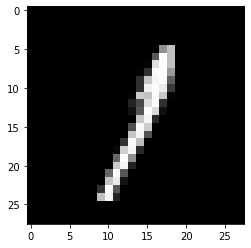

In [ ]:
plt.imshow(train_dataset.data[1081], cmap = "gray")

In [ ]:
train_index[256]

1081

### BCE

In [20]:
class BCE_LR(nn.Module):
  def __init__(self, input_size,  num_classes):
    super(BCE_LR, self).__init__()
    self.linear = nn.Linear(input_size, num_classes-1, bias = False)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    out = self.linear(x)
    out = self.sigmoid(out)
    return out

In [21]:
input_size = 784 # 28*28
num_classes = 2
num_epochs = 10
batch_size = 100
learning_rate = 0.001

training_size = len(train_index)
testing_size = len(test_index)

In [22]:
testing_size

2163

In [23]:
alpha_train_dataset = One_Seven_Train_Dataset()
train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=batch_size, shuffle=True)

model = BCE_LR(input_size, num_classes).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        #images = images.reshape(-1, 28*28).to(device) # can change -1 to 100
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

        labels = labels.reshape(-1, 1).float().to(device)

        # forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()

alpha_test_dataset = One_Seven_Test_Dataset()
test_loader = torch.utils.data.DataLoader(dataset=alpha_test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        # 把一个batch reshape 成一个 100 by 784 的 vector 来做prediction
        #images = images.reshape(-1, 28*28).to(device)
        images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)
        
        labels = labels.to(device)
        output = model(images)
        # value, index
        
        n_samples += labels.shape[0]
        n_correct += (output.reshape(-1).round().eq(labels)*1).sum().item()
    
    acc = 100 * n_correct/n_samples

In [24]:
    def save_checkpoint_classification(file_path, silent=True):
        model_states = {'classification': model.state_dict(), }
        optim_states = {'classification': optimizer.state_dict(), }
        states = {'epoch': 10,
                  'model_states': model_states,
                  'optim_states': optim_states}
        with open(file_path, mode='wb+') as f:
            torch.save(states, f)
        if not silent:
            print(
                "=> saved checkpoint '{}' (iter {})".format(
                    file_path, self.global_iter))

In [77]:
save_checkpoint_classification("../checkpoints/fenchel/mnist/MNIST_LogisticRegression/classOneAndSevenAll.pt")

In [26]:
model

BCE_LR(
  (linear): Linear(in_features=784, out_features=1, bias=False)
  (sigmoid): Sigmoid()
)

In [27]:
acc

98.19694868238558

In [33]:
w = list(model.parameters())[0][0].detach()

In [34]:
total_loss = 0


for i in range(len(train_index)):
    out1 = model(alpha_train_dataset[i][0].reshape(-1,784).float().to(device))
    loss1 = criterion(out1[0], torch.tensor([alpha_train_dataset[i][1]]).float().to(device))
    #total_loss += loss1
    if loss1 > 2.6:
        print(loss1)
        break

tensor(100., grad_fn=<BinaryCrossEntropyBackward0>)


In [74]:
def BCE_loss_all(w):
    
    train_loader = torch.utils.data.DataLoader(dataset=alpha_train_dataset, batch_size=training_size, shuffle=False)
    examples = iter(train_loader)
    images, labels = examples.next()

    images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    out1 = torch.sigmoid(F.linear(images, w.reshape(1,784)))


    #out1 = torch.sigmoid(F.linear(images.reshape(-1, 784).to(device), w.reshape(1,784)))

    loss = criterion(out1.reshape(-1), labels.float().to(device))*training_size
    print(loss)
    return loss

def BCE_loss_single_point(w, i):
    
    images = alpha_train_dataset[i][0].float()

    temp_label = torch.tensor([train_labels[i]]).float()

    out1 = torch.sigmoid(F.linear(images.reshape(-1, 784).to(device), w.reshape(1,784)))

    loss = criterion(out1[0], temp_label.to(device))

    return loss

def BCE_loss_grad_train_point(w, i):
    
    w = w.clone().detach().requires_grad_(True)

    images = alpha_train_dataset[i][0].float()

    images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    temp_label = torch.tensor([train_labels[i]]).float()

    out1 = torch.sigmoid(F.linear(images, w.reshape(1,784)))

    loss = criterion(out1[0], temp_label.to(device))

    loss.backward()

    return w.grad


def BCE_loss_grad_test_point(w, i):
    
    w = w.clone().detach().requires_grad_(True)

    images = alpha_test_dataset[i][0].float()

    images = ((images.reshape(-1, 28*28)/255- 0.1307)/0.3081).to(device)

    temp_label = torch.tensor([test_labels[i]]).float()

    out1 = torch.sigmoid(F.linear(images, w.reshape(1,784)))

    loss = criterion(out1[0], temp_label.to(device))

    loss.backward()

    return w.grad



def BCE_loss_34(w):
    
    images = alpha_train_dataset[34][0].float()

    temp_label = torch.tensor([train_labels[34]]).float()

    out1 = torch.sigmoid(F.linear(images.reshape(-1, 784).to(device), w.reshape(1,784)))

    loss = criterion(out1[0], temp_label.to(device))

    ####

    #out1 = F.linear(images.reshape(-1, 784).to(device), w.reshape(1,784))

    #images = alpha_train_dataset[34][0].float().reshape(-1, 784)[0].t()

    #out1 = torch.matmul(images, w)

    #out1 = torch.sigmoid(out1)
    
    #loss = criterion(out1, temp_label.to(device))

    return loss

In [75]:
with torch.no_grad():
   Hessian = hessian(BCE_loss_all, w.clone().detach().requires_grad_(True))/training_size

tensor(705.5736, grad_fn=<MulBackward0>)


In [73]:
np.save("../checkpoints/fenchel/mnist/MNIST_LogisticRegression/numpy_hessian_first1000.pt.npy", Hessian)

In [41]:
Hessian[100]

tensor([ 4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9469e-03,  4.9516e-03,  4.9382e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,  4.9359e-03,
         4.9359e-03,  4.9340e-03,  4.9309e-03,  4.9

In [38]:
damping_matrix = torch.tensor(np.diag(np.full(Hessian.shape[0],0.001),0)).to(device)
damping_hessian = Hessian + damping_matrix
inv_hessian = torch.linalg.inv(damping_hessian)

In [39]:
inv_hessian

tensor([[996.7611,  -3.2389,  -3.2389,  ...,  -3.2389,  -3.2389,  -3.2389],
        [ -3.2389, 996.7611,  -3.2389,  ...,  -3.2389,  -3.2389,  -3.2389],
        [ -3.2389,  -3.2389, 996.7611,  ...,  -3.2389,  -3.2389,  -3.2389],
        ...,
        [ -3.2389,  -3.2389,  -3.2389,  ..., 996.7611,  -3.2389,  -3.2389],
        [ -3.2389,  -3.2389,  -3.2389,  ...,  -3.2389, 996.7611,  -3.2389],
        [ -3.2389,  -3.2389,  -3.2389,  ...,  -3.2389,  -3.2389, 996.7611]],
       dtype=torch.float64)

In [78]:
np.save("../checkpoints/fenchel/mnist/MNIST_LogisticRegression/numpy_inv_hessian_classOneAndSevenAll.pt", Hessian)

In [69]:
def calculate_if(train_index, test_index, inv_Hessian):
    # test point should be alpha_test_dataset[10]

    test_loss = BCE_loss_grad_test_point(w, test_index)
   
    train_loss = BCE_loss_grad_train_point(w, train_index)
#     print(test_loss)
    print(train_loss)
    if_score = -torch.matmul(torch.matmul(test_loss.t().double(), inv_Hessian), train_loss.double())

    return if_score

def calculate_if_no_hessian(train_index, test_index):
    # test point should be alpha_test_dataset[10]

    test_loss = BCE_loss_grad_test_point(w, test_index)

    train_loss = BCE_loss_grad_train_point(w, train_index)

    if_score = -torch.matmul(test_loss.t().double(), train_loss.double())

    return if_score

In [71]:
calculate_if(0,1,inv_hessian)

tensor([-0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079, -0.0079,
        -0.0079, -0.0079, -0.0079, -0.00

tensor(0.0500, dtype=torch.float64)

In [70]:
calculate_if_no_hessian(0,1)

TypeError: calculate_if() missing 1 required positional argument: 'inv_Hessian'

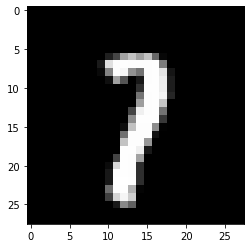

In [66]:
plt.imshow(alpha_test_dataset[30][0], cmap = "gray")

In [67]:
if_score_list = []
for i in range(training_size):
    if_score = calculate_if(i, 30, inv_hessian)
    if_score_list.append(if_score.item())

In [68]:
if_score_list_no_hessian = []
for i in range(training_size):
    if_score = calculate_if_no_hessian(i, 30)
    if_score_list_no_hessian.append(if_score.item())

In [69]:
if_score_series = pd.Series(if_score_list)
if_score_series_sorted = if_score_series.sort_values(ascending = False)
if_score_series_sorted

4528     436.691276
9822     429.115419
11368    392.325760
893      344.551329
11781    342.638730
            ...    
5773    -330.725750
5756    -338.761383
8364    -430.982855
9459    -525.030371
994     -569.462098
Length: 13007, dtype: float64

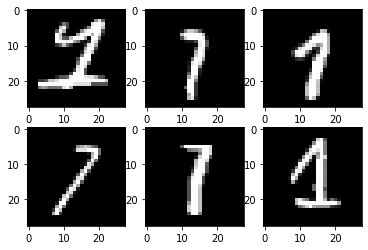

In [70]:
fig, axs = plt.subplots(2, 3)
axs[0][0].imshow(alpha_train_dataset[if_score_series_sorted.index[-1]][0], cmap = "gray")
axs[0][1].imshow(alpha_train_dataset[if_score_series_sorted.index[-2]][0], cmap = "gray")
axs[0][2].imshow(alpha_train_dataset[if_score_series_sorted.index[-3]][0], cmap = "gray")
axs[1][0].imshow(alpha_train_dataset[if_score_series_sorted.index[0]][0], cmap = "gray")
axs[1][1].imshow(alpha_train_dataset[if_score_series_sorted.index[1]][0], cmap = "gray")
axs[1][2].imshow(alpha_train_dataset[if_score_series_sorted.index[2]][0], cmap = "gray")

In [71]:
alpha_train_dataset[if_score_series_sorted.index[2]][1]

tensor(0)

In [72]:
if_score_list_with_hessian = if_score_list

In [98]:
len(if_score_list_with_hessian)

13007

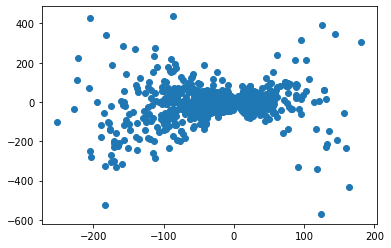

In [73]:
scatter(if_score_list_no_hessian,if_score_list_with_hessian)

In [103]:
np.corrcoef(if_score_list_with_hessian, if_score_list_no_hessian)

array([[1.        , 0.18409358],
       [0.18409358, 1.        ]])

In [104]:
if_score_list_no_hessian

[5.341809720828467,
 2.7888966489256526,
 3.408776615789886,
 2.3194309975471574,
 -0.15556116165863768,
 8.048136152869139,
 51.769925044693096,
 -46.380889875606954,
 -1.0732722151287057,
 2.3659970569163917,
 -11.74838698596934,
 -0.014489078841847289,
 2.049011964363215,
 2.984415460817873,
 5.648026885421373,
 -4.578495874600488,
 2.030716970362593,
 2.4150505874423387,
 26.0274900369496,
 -8.256682127350352,
 -0.19269204602080547,
 -0.589129658860611,
 -1.4979734204683868,
 20.694213138610742,
 -0.7968023543726596,
 1.223465396503932,
 -0.1758644213788202,
 5.497746341178858,
 0.8465431970328441,
 2.3245460536626097,
 0.9565772871992413,
 -0.2661950278466634,
 3.6981691186165166,
 1.5908969383298337,
 55.808397009237034,
 -15.489264772416728,
 -28.34830489777466,
 -8.780308615976939,
 1.62480514911464,
 -0.25719122865168176,
 -24.044026838058876,
 4.465487951232126,
 17.266833844895473,
 2.04168239785143,
 -0.10672687717821934,
 -0.3198305720285989,
 -0.013014796141129584,
 3.690